<a href="https://colab.research.google.com/github/canislatranscoxus/gcp_ml_certification/blob/master/4b_keras_dnn_babyweight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Keras dnn Babyweight
Canis notes.

In this notebook we load our CSV dataset of mothers and we want to predict baby weigth before birth.

My practice using  `4b_keras_dnn_babyweight.ipynb`
as reference

https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/structured/solutions/4b_keras_dnn_babyweight.ipynb







### load needed libraries

In [ ]:
import tensorflow as tf
import datetime
import os

print( 'tensorflow version: {} '.format( tf.__version__ ) )

tensorflow version: 2.3.0 


### load CSV funtion

* train.csv
* eval.csv
* test.csv

these files were created in 4a_sample_babyweight


In [ ]:
# this is what we want to predict
LABEL_COLUMN = "weight_pounds"

CSV_COLUMNS = [ "weight_pounds", "is_male", "mother_age", "plurality", "gestation_weeks"]
DEFAULTS    = [ [0.0]          , ["null"] , [0.0]       , ["null"]   , [0.0]            ]
               

In [ ]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label


def load_dataset(pattern, batch_size=1, mode='eval'):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: 'train' | 'eval' to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern    = pattern,
        batch_size      = batch_size,
        column_names    = CSV_COLUMNS,
        column_defaults = DEFAULTS)

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # Shuffle and repeat for training
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

### functions needed for Model 

here we declare some functions:

* categorical_fc()
* get_model_outputs()
* create_input_layers()
* create_feature_columns()
* rmse()

### Features in the Model.

Features are numeric columns that can be used in the model.

the most used are:

* Numeric Column     --> numeric_column

* Categorical Column (one hot encoding) -->   
    * categorical_column_with_vocabulary_list
    * indicator_column

* Categorical Column --> 
    * categorical_column_with_vocabulary_list
    * embedding_column

* bucketized_column (numeric ) --> 
    * numeric_column
    * bucketized_column

* Crossed features --> crossed_column




There are many, look here
https://www.tensorflow.org/tutorials/structured_data/feature_columns






In [ ]:
def create_input_layers():
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="float32")
        for colname in ["mother_age", "gestation_weeks"]}

    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="string")
        for colname in ["is_male", "plurality"]})

    return inputs

In [ ]:
def categorical_fc(name, values):
    """Helper function to wrap categorical feature by indicator column.

    Args:
        name: str, name of feature.
        values: list, list of strings of categorical values.
    Returns:
        Indicator column of categorical feature.
    """
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)

    return tf.feature_column.indicator_column(categorical_column=cat_column)


In [ ]:
def create_feature_columns():
    """Creates dictionary of feature columns from inputs.

    Returns:
        Dictionary of feature columns.
    """
    feature_columns = {
        colname : tf.feature_column.numeric_column(key=colname)
           for colname in ["mother_age", "gestation_weeks"]
    }

    feature_columns["is_male"] = categorical_fc(
        "is_male", ["True", "False", "Unknown"])
    
    feature_columns["plurality"] = categorical_fc(
        "plurality", ["Single(1)", "Twins(2)", "Triplets(3)", "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"])

    return feature_columns

### create DNN hidden layers and output

In [ ]:
def get_model_outputs(inputs):
    """Creates model architecture and returns outputs.

    Args:
        inputs: Dense tensor used as inputs to model.
    Returns:
        Dense tensor output from the model.
    """
    # Create two hidden layers of [64, 32] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(64, activation="relu", name="h1")( inputs)
    h2 = tf.keras.layers.Dense(32, activation="relu", name="h2")( h1    )

    # Final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(
        units=1, activation="linear", name="weight")( h2 )

    return output

### evaluation metric

In [ ]:
def rmse(y_true, y_pred):
    """Calculates RMSE evaluation metric.

    Args:
        y_true: tensor, true labels.
        y_pred: tensor, predicted labels.
    Returns:
        Tensor with value of RMSE between true and predicted labels.
    """
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

### The Deep Neural Network Model

will have this Architecture














In [ ]:
def build_dnn_model():
    """Builds simple DNN using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers()

    # Create feature columns
    feature_columns = create_feature_columns()

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
plurality (InputLayer)          [(None,)]            0                                            
_________________________________________________

In [ ]:
pip install graphviz

In [ ]:
from graphviz import Digraph

g = Digraph()
# Add nodes 1 and 2

with g.subgraph(name='cluster_input_layer') as c:
  c.attr(style='filled', color='pink', rankdir='TB')
  c.attr(label='input layer')
  c.node_attr.update(style='filled', color='magenta')
  
  for column in CSV_COLUMNS:
    if column == "weight_pounds":
      continue
    c.node( column  )

with g.subgraph(name='cluster_dense_layer') as c:
  c.attr(style='filled', color='blue', rankdir='TB')
  c.node( 'dense_features'  ,color='cyan', style='filled', fillcolor='cyan'    )
  c.edge( 'is_male'         , 'dense_features', constraint='false')
  c.edge( 'mother_age'      , 'dense_features', constraint='false')
  c.edge( 'plurality'       , 'dense_features', constraint='false')
  c.edge( 'gestation_weeks' , 'dense_features', constraint='false')


g.node( 'h1'    ,color='yellow', style='filled', fillcolor='yellow'    )
g.node( 'h2'    ,color='yellow', style='filled', fillcolor='yellow'    )
g.node( 'weight', color='green', style='filled', fillcolor='green'   )

g.edge( 'dense_features', 'h1'     , constraint='false' )
g.edge( 'h1'            , 'h2'     , constraint='false' )
g.edge( 'h2'            , 'weight' , constraint='false' )


### Deep Neural Architecture

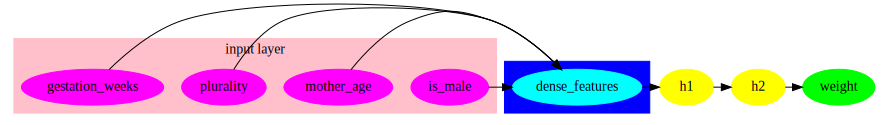

In [ ]:
g

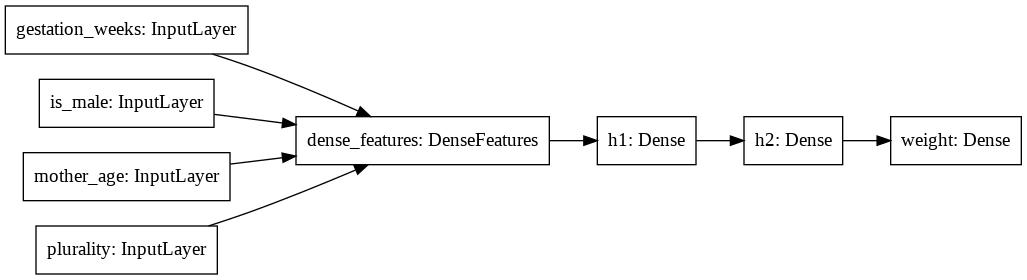

In [ ]:
tf.keras.utils.plot_model(
    model=model, to_file="dnn_model.png", show_shapes=False, rankdir="LR")

### run and evaluate

In [ ]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset repeats, it'll wrap around
NUM_EVALS = 5  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10000

trainds = load_dataset(
    pattern     ="train*",
    batch_size  =TRAIN_BATCH_SIZE,
    mode        ='train')

evalds = load_dataset(
    pattern     ="eval*",
    batch_size  =1000,
    mode        ='eval').take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join( "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )
tensorboard_callback = tf.keras.callbacks.TensorBoard( log_dir=logdir, histogram_freq=1)

history = model.fit(
    trainds,
    validation_data =evalds,
    epochs          =NUM_EVALS,
    steps_per_epoch =steps_per_epoch,
    callbacks       =[tensorboard_callback])

### visualize loss curve

In [ ]:
# Plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "rmse"]):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history["val_{}".format(key)])
    plt.title("model {}".format(key))
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

### save Model

In [ ]:
OUTPUT_DIR = "babyweight_trained"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

EXPORT_PATH = os.path.join( OUTPUT_DIR, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))

tf.saved_model.save( obj=model, export_dir=EXPORT_PATH)  # with default serving function

print("Exported trained model to {}".format(EXPORT_PATH))